# PL04 - Data Integration and Processing I

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

In [2]:
energy_consumption = pd.read_csv('DataSets/change-energy-consumption.csv')
renewable_energy = pd.read_csv('DataSets/modern-renewable-prod.csv')
per_capita_energy_use = pd.read_csv('DataSets/per-capita-energy-use.csv')
primary_energy = pd.read_csv('DataSets/primary-energy-cons.csv')

In [3]:
energy_consumption.head()

,Entity,Code,Year,Annual change in primary energy consumption (%)
0,Afghanistan,AFG,1981,12.663031
1,Afghanistan,AFG,1982,6.505477
2,Afghanistan,AFG,1983,22.333790
3,Afghanistan,AFG,1984,0.462401
4,Afghanistan,AFG,1985,-2.365375


### **Energy Data Analysis**

This analysis merges multiple datasets related to energy consumption, primary energy, renewable energy, and per capita energy use.


In [4]:
energy_analysis1 = pd.merge(energy_consumption,primary_energy, on=['Entity','Code','Year'], how='left')
energy_analysis2 = pd.merge(energy_analysis1,renewable_energy, on=['Entity','Code','Year'], how='left')
energy_analysis = pd.merge(energy_analysis2, per_capita_energy_use, on=['Entity','Code','Year'], how='left')

In [92]:
energy_analysis

,Entity,Code,Year,Annual change in primary energy consumption (%),Primary energy consumption (TWh),Electricity from wind - TWh,Electricity from hydro - TWh,Electricity from solar - TWh,Other renewables including bioenergy - TWh,Primary energy consumption per capita (kWh/person)
0,Afghanistan,AFG,1981,12.663031,8.777320,NaN,NaN,NaN,NaN,786.83690
1,Afghanistan,AFG,1982,6.505477,9.348327,NaN,NaN,NaN,NaN,926.65125
2,Afghanistan,AFG,1983,22.333790,11.436162,NaN,NaN,NaN,NaN,1149.19590
3,Afghanistan,AFG,1984,0.462401,11.489043,NaN,NaN,NaN,NaN,1121.57290
4,Afghanistan,AFG,1985,-2.365375,11.217284,NaN,NaN,NaN,NaN,1067.07090
...,...,...,...,...,...,...,...,...,...,...
11717,Zimbabwe,ZWE,2017,-2.984351,45.256546,0.0,3.97,0.01,0.15,3068.01150
11718,Zimbabwe,ZWE,2018,14.479410,51.809430,0.0,5.05,0.02,0.19,3441.98580
11719,Zimbabwe,ZWE,2019,-10.981565,46.119940,0.0,4.17,0.03,0.19,3003.65530
11720,Zimbabwe,ZWE,2020,-8.940124,41.996760,0.0,3.81,0.02,0.10,2680.13180


### Dropping rows with missing Code values

Ensures all entries have a valid country or region code.

Rows without a Code correspond to continents rather than individual countries.

Removing these rows prevents aggregation errors and ensures consistency in country-level analysis.

The code 'OWID_WRL' represents a global entity that aggregates data from all countries. Since the analysis focuses on individual countries, excluding this row ensures that the dataset only includes country-specific data, preventing distortions in statistical calculations.

In [5]:
energy_analysis = energy_analysis.dropna(subset=['Code'])

In [6]:
energy_analysis = energy_analysis[energy_analysis['Code'] != 'OWID_WRL']

### Common years for all the countries

In [7]:
energy_analysis.groupby("Entity")["Year"].min()

Entity
Afghanistan       1981
Albania           1981
Algeria           1966
American Samoa    1981
Angola            1981
                  ... 
Western Sahara    1981
Yemen             1981
Yugoslavia        1981
Zambia            1981
Zimbabwe          1981
Name: Year, Length: 223, dtype: int64

In [8]:
energy_analysis.groupby("Entity")["Year"].max()

Entity
Afghanistan       2021
Albania           2021
Algeria           2023
American Samoa    2021
Angola            2021
                  ... 
Western Sahara    2021
Yemen             2021
Yugoslavia        1991
Zambia            2021
Zimbabwe          2021
Name: Year, Length: 223, dtype: int64

### Data Filtering for Consistency Across Countries

Yugoslavia no longer exists since 1991, so it only has data up to that year. We’ll remove this country from the dataset.

Most countries have data available up to 2021, so we will discard those that have data extending into 2022 and 2023.

Additionally, most countries have data starting from 1981, so we will eliminate any records prior to this year.

In [9]:
energy_analysis = energy_analysis[energy_analysis["Entity"] != "Yugoslavia"]
energy_analysis = energy_analysis[energy_analysis["Year"] <= 2021]
energy_analysis = energy_analysis[energy_analysis["Year"] >= 1981]

In [10]:
# Checking for missing values to identify columns with incomplete data

energy_analysis.isna().sum()

Entity                                                   0
Code                                                     0
Year                                                     0
Annual change in primary energy consumption (%)          0
Primary energy consumption (TWh)                         0
Electricity from wind - TWh                           2769
Electricity from hydro - TWh                          2569
Electricity from solar - TWh                          2796
Other renewables including bioenergy - TWh            2718
Primary energy consumption per capita (kWh/person)      88
dtype: int64

### Handling Missing Values

The missing values correspond to renewable energy data for the years 1981 to 1999. This likely indicates that renewable energy sources were not widely used or reported during this period for some countries.
To ensure consistency in the dataset and avoid misinterpretation of missing values, we will replace these NA values with 0, assuming that renewable energy usage was negligible or nonexistent at that time.

In [11]:
energy_analysis.fillna(0, inplace=True)

### Outliers Detetion

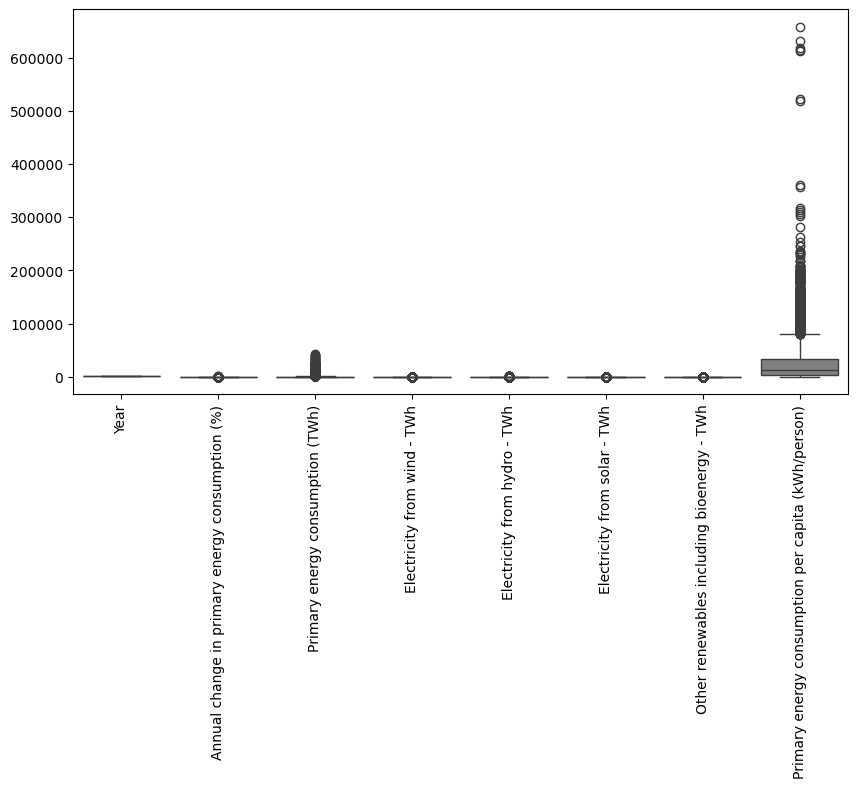

In [13]:
plt.figure(figsize=(10, 5))
sns.boxplot(data=energy_analysis.select_dtypes(include=['float64', 'int64']))
plt.xticks(rotation=90)
plt.show()


The boxplot reveals significant differences in the scale of the variables, with some (such as "Primary energy consumption (TWh)" and "Primary energy consumption per capita (kWh/person)") having extremely high values, while others are close to zero. This highlights the necessity of standardizing the data. Here’s why:

1. **Outliers and Scale Differences**: The presence of outliers in several columns, especially in "Primary energy consumption per capita (kWh/person)," shows that the data ranges vary greatly. Variables with vastly different scales can distort the analysis.
   
2. **Impact on Comparisons**: The current format makes it difficult to make direct comparisons between variables due to the differing units and ranges.

3. **Improving Model Performance**: Standardization transforms the data to have a mean of 0 and a standard deviation of 1. This makes the variables comparable and helps improve the performance of many statistical techniques and machine learning algorithms, particularly those that rely on distance-based measures, such as clustering or regression models.

For these reasons, we decide to use **StandardScaler (Z-score normalization)**  to standardize the data and allow for easier comparisons across variables.


In [ ]:
# Define columns for standardization
cols_to_scale = [
    "Primary energy consumption (TWh)",
    "Primary energy consumption per capita (kWh/person)",
    "Electricity from wind - TWh",
    "Electricity from hydro - TWh",
    "Electricity from solar - TWh",
    "Other renewables including bioenergy - TWh"
]

# Apply standardization (Z-score)
scaler = StandardScaler()
energy_analysis[cols_to_scale] = scaler.fit_transform(energy_analysis[cols_to_scale])


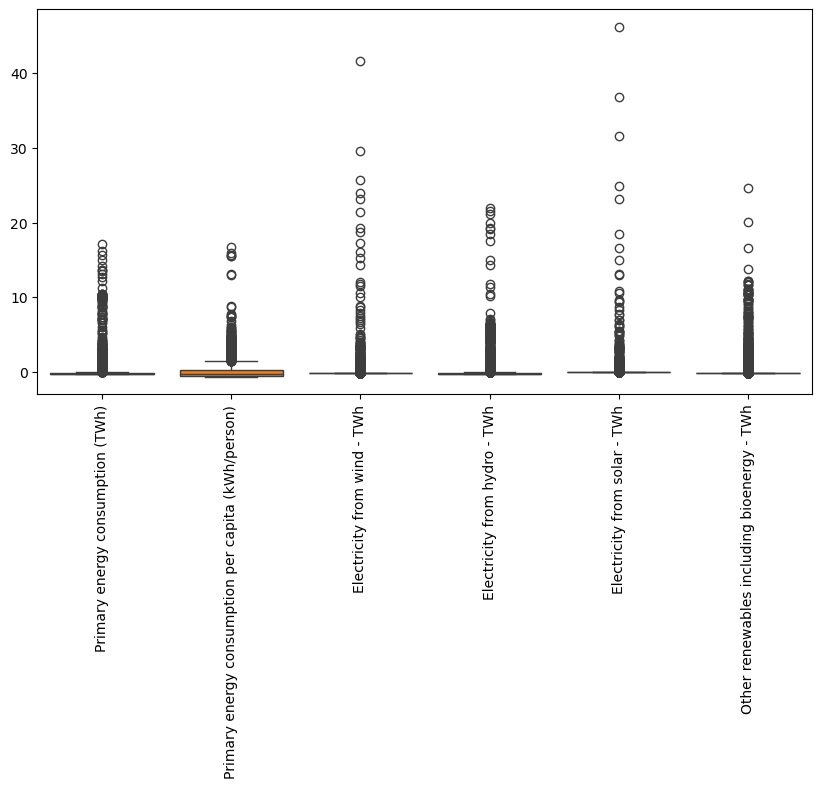

In [ ]:
# Recreate the boxplot to verify the result
plt.figure(figsize=(10, 5))
sns.boxplot(data=energy_analysis[cols_to_scale])
plt.xticks(rotation=90)
plt.show()

In [20]:
# Exporting our new DataSet into a csv type file

energy_analysis.to_csv('Energy_Analysis.csv', index=False)

### Timer

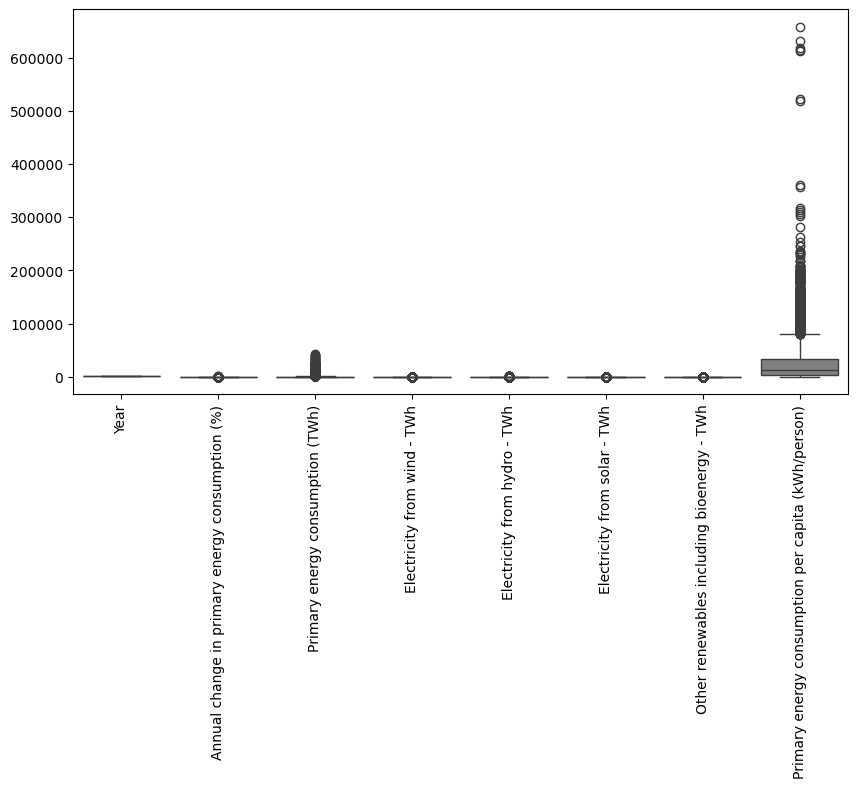

Tempo de execução em Python: 1.3901 segundos


In [14]:
import time
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

def algoritmo_python():
    
    energy_consumption = pd.read_csv('DataSets/change-energy-consumption.csv')
    renewable_energy = pd.read_csv('DataSets/modern-renewable-prod.csv')
    per_capita_energy_use = pd.read_csv('DataSets/per-capita-energy-use.csv')
    primary_energy = pd.read_csv('DataSets/primary-energy-cons.csv')
    energy_consumption.head()
    energy_analysis1 = pd.merge(energy_consumption,primary_energy, on=['Entity','Code','Year'], how='left')
    energy_analysis2 = pd.merge(energy_analysis1,renewable_energy, on=['Entity','Code','Year'], how='left')
    energy_analysis = pd.merge(energy_analysis2, per_capita_energy_use, on=['Entity','Code','Year'], how='left')
    energy_analysis = energy_analysis.dropna(subset=['Code'])
    energy_analysis = energy_analysis[energy_analysis['Code'] != 'OWID_WRL']
    energy_analysis.groupby("Entity")["Year"].min()
    energy_analysis.groupby("Entity")["Year"].max()
    energy_analysis = energy_analysis[energy_analysis["Entity"] != "Yugoslavia"]
    energy_analysis = energy_analysis[energy_analysis["Year"] <= 2021]
    energy_analysis = energy_analysis[energy_analysis["Year"] >= 1981]
    energy_analysis.isna().sum()
    energy_analysis.fillna(0, inplace=True)
    energy_analysis.to_csv('Energy_Analysis.csv', index=False)
    plt.figure(figsize=(10, 5))
    sns.boxplot(data=energy_analysis.select_dtypes(include=['float64', 'int64']))
    plt.xticks(rotation=90)
    plt.show()
  
    soma = sum(range(10**6))  # Exemplo de operação
    return soma

inicio = time.time()
resultado_python = algoritmo_python()
fim = time.time()

tempo_python = fim - inicio
print(f"Tempo de execução em Python: {tempo_python:.4f} segundos")

### PySpark

In [ ]:
#!pip install pyspark

     ---------------------------------------- 0.0/317.2 MB ? eta -:--:--
      -------------------------------------- 4.2/317.2 MB 25.2 MB/s eta 0:00:13
     - ------------------------------------ 11.8/317.2 MB 30.8 MB/s eta 0:00:10
     - ------------------------------------ 14.4/317.2 MB 25.9 MB/s eta 0:00:12
     - ------------------------------------ 15.7/317.2 MB 20.2 MB/s eta 0:00:15
     -- ----------------------------------- 17.0/317.2 MB 16.5 MB/s eta 0:00:19
     -- ----------------------------------- 18.1/317.2 MB 15.0 MB/s eta 0:00:20
     -- ----------------------------------- 19.1/317.2 MB 13.3 MB/s eta 0:00:23
     -- ----------------------------------- 19.9/317.2 MB 12.3 MB/s eta 0:00:25
     -- ----------------------------------- 21.0/317.2 MB 11.3 MB/s eta 0:00:27
     -- ----------------------------------- 21.5/317.2 MB 10.5 MB/s eta 0:00:29
     -- ------------------------------------ 22.0/317.2 MB 9.7 MB/s eta 0:00:31
     -- ------------------------------------ 22

In [15]:
from pyspark.sql import SparkSession
import time

spark = SparkSession.builder.appName("ComparacaoPythonPySpark").getOrCreate()

def algoritmo_pyspark():
    rdd = spark.sparkContext.parallelize(range(10**6))
    return rdd.sum()

inicio = time.time()
resultado_pyspark = algoritmo_pyspark()
fim = time.time()

tempo_pyspark = fim - inicio
print(f"Tempo de execução em PySpark: {tempo_pyspark:.4f} segundos")

spark.stop()

Py4JJavaError: An error occurred while calling z:org.apache.spark.api.python.PythonRDD.collectAndServe.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 5 in stage 5.0 failed 1 times, most recent failure: Lost task 5.0 in stage 5.0 (TID 45) (catarina executor driver): java.io.IOException: Cannot run program "python3": CreateProcess error=2, O sistema não conseguiu localizar o ficheiro especificado
	at java.lang.ProcessBuilder.start(Unknown Source)
	at org.apache.spark.api.python.PythonWorkerFactory.createSimpleWorker(PythonWorkerFactory.scala:181)
	at org.apache.spark.api.python.PythonWorkerFactory.create(PythonWorkerFactory.scala:109)
	at org.apache.spark.SparkEnv.createPythonWorker(SparkEnv.scala:124)
	at org.apache.spark.api.python.BasePythonRunner.compute(PythonRunner.scala:174)
	at org.apache.spark.api.python.PythonRDD.compute(PythonRDD.scala:67)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:367)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:331)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:93)
	at org.apache.spark.TaskContext.runTaskWithListeners(TaskContext.scala:166)
	at org.apache.spark.scheduler.Task.run(Task.scala:141)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$4(Executor.scala:620)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally(SparkErrorUtils.scala:64)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally$(SparkErrorUtils.scala:61)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:94)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:623)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(Unknown Source)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(Unknown Source)
	at java.lang.Thread.run(Unknown Source)
Caused by: java.io.IOException: CreateProcess error=2, O sistema não conseguiu localizar o ficheiro especificado
	at java.lang.ProcessImpl.create(Native Method)
	at java.lang.ProcessImpl.<init>(Unknown Source)
	at java.lang.ProcessImpl.start(Unknown Source)
	... 19 more

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.failJobAndIndependentStages(DAGScheduler.scala:2856)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2(DAGScheduler.scala:2792)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2$adapted(DAGScheduler.scala:2791)
	at scala.collection.mutable.ResizableArray.foreach(ResizableArray.scala:62)
	at scala.collection.mutable.ResizableArray.foreach$(ResizableArray.scala:55)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:2791)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1(DAGScheduler.scala:1247)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1$adapted(DAGScheduler.scala:1247)
	at scala.Option.foreach(Option.scala:407)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:1247)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:3060)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2994)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2983)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:989)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2393)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2414)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2433)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2458)
	at org.apache.spark.rdd.RDD.$anonfun$collect$1(RDD.scala:1049)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:410)
	at org.apache.spark.rdd.RDD.collect(RDD.scala:1048)
	at org.apache.spark.api.python.PythonRDD$.collectAndServe(PythonRDD.scala:195)
	at org.apache.spark.api.python.PythonRDD.collectAndServe(PythonRDD.scala)
	at sun.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at sun.reflect.NativeMethodAccessorImpl.invoke(Unknown Source)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(Unknown Source)
	at java.lang.reflect.Method.invoke(Unknown Source)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:374)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.ClientServerConnection.waitForCommands(ClientServerConnection.java:182)
	at py4j.ClientServerConnection.run(ClientServerConnection.java:106)
	at java.lang.Thread.run(Unknown Source)
Caused by: java.io.IOException: Cannot run program "python3": CreateProcess error=2, O sistema não conseguiu localizar o ficheiro especificado
	at java.lang.ProcessBuilder.start(Unknown Source)
	at org.apache.spark.api.python.PythonWorkerFactory.createSimpleWorker(PythonWorkerFactory.scala:181)
	at org.apache.spark.api.python.PythonWorkerFactory.create(PythonWorkerFactory.scala:109)
	at org.apache.spark.SparkEnv.createPythonWorker(SparkEnv.scala:124)
	at org.apache.spark.api.python.BasePythonRunner.compute(PythonRunner.scala:174)
	at org.apache.spark.api.python.PythonRDD.compute(PythonRDD.scala:67)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:367)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:331)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:93)
	at org.apache.spark.TaskContext.runTaskWithListeners(TaskContext.scala:166)
	at org.apache.spark.scheduler.Task.run(Task.scala:141)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$4(Executor.scala:620)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally(SparkErrorUtils.scala:64)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally$(SparkErrorUtils.scala:61)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:94)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:623)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(Unknown Source)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(Unknown Source)
	... 1 more
Caused by: java.io.IOException: CreateProcess error=2, O sistema não conseguiu localizar o ficheiro especificado
	at java.lang.ProcessImpl.create(Native Method)
	at java.lang.ProcessImpl.<init>(Unknown Source)
	at java.lang.ProcessImpl.start(Unknown Source)
	... 19 more


In [13]:
print(f"Python foi {tempo_python / tempo_pyspark:.2f} vezes mais rápido que PySpark" if tempo_python < tempo_pyspark else 
      f"PySpark foi {tempo_pyspark / tempo_python:.2f} vezes mais rápido que Python")

NameError: name 'tempo_pyspark' is not defined